In [1]:
# Imports.
import nltk
import numpy as np
import pandas as pd
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from nltk.corpus import stopwords
import csv
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
import collections
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.cm as cm
import fasttext
import hdbscan

In [2]:
# GLobal variables.
STOP_WORDS = set(stopwords.words('english'))

In [3]:
# Functions.

# TF-IDF vectorizer.
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,1),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=STOP_WORDS)

# Get most relevant words from tf-idf.
def get_tfidf(corpus):
    scores = {}
    
    # Matrix of scored terms for each comment in the corpus.
    tfidf_matrix =  vectorizer.fit_transform(corpus)
    
    # Mapping of terms to matrix ids.
    feature_names = vectorizer.get_feature_names()
    
    # For each comment extract the terms and scores and append them to a dictionary.
    for i in range(len(corpus)):
        feature_index = tfidf_matrix[i,:].nonzero()[1]
        tfidf_scores = zip([feature_names[y] for y in feature_index], [tfidf_matrix[i, x] for x in feature_index])
        scores.update(dict(tfidf_scores))
    return scores

In [4]:
# Load FastText common crawl model.
vector_path = 'crawl-300d-2M-subword.bin'
model = fasttext.load_model(vector_path)

In [5]:
# Load raw dataset.
df_raw = pd.read_csv("../../data/pnlp_data_en.csv", delimiter=';')
df_raw.head(5)

,Report Grouping,Question Text,Comments
0,Large Department,Please tell us what is working well.,"we do what our customers need, we communicate ..."
1,Large Department,Please tell us what is working well.,Customs business development continues to grow...
2,Large Department,Please tell us what is working well.,"I think the team work hard, are committed to c..."
3,Large Department,Please tell us what is working well.,Overall working towards a customer centric env...
4,Large Department,Please tell us what is working well.,Customer centricity is a growing culture in th...


In [6]:
# Train sentence tokenizer.
corpus = ''
for index, row in df_raw.iterrows():
    corpus += row['Comments'].lower().replace('•', '') + ' '

# NLTK function for building tokenization model based on our comment data.
trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(corpus)
tokenizer = PunktSentenceTokenizer(trainer.get_params())

In [7]:
# Sentence tokenize the comments.
comments_tokenized = []
for index, row in df_raw.iterrows():
    for sentence in tokenizer.tokenize(row['Comments']):
        comment = sentence.lower().replace('•', '')
        comments_tokenized.append({'Question': row['Question Text'], 'Comment': comment})

In [8]:
# Load sentence tokenized comments to a new df.
df_tokenized = pd.DataFrame(comments_tokenized)
df_tokenized.head(5)

,Question,Comment
0,Please tell us what is working well.,"we do what our customers need, we communicate ..."
1,Please tell us what is working well.,customs business development continues to grow...
2,Please tell us what is working well.,"i think the team work hard, are committed to c..."
3,Please tell us what is working well.,overall working towards a customer centric env...
4,Please tell us what is working well.,customer centricity is a growing culture in th...


In [9]:
# Mean embeddings for each sentence.

# Write to a csv so we have the results saved on the disk.
with open('data_tm.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['Question', 'Comment', 'Mean Embedding']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    for index, row in df_tokenized.iterrows():
        # Ignore stop words.
        tokens = [w for w in nltk.tokenize.word_tokenize(row['Comment']) if not w in STOP_WORDS]
        if len(tokens) > 1:
            embeddings = []
            for token in tokens:
                try:
                    embeddings.append(model[token])
                
                # Ignore the word if the model can't vectorize it.
                except KeyError as e:
                    pass

            # Compute mean embeddings.
            mean_embedding = np.array(embeddings).mean(axis=0)    

        # If there is only one valid word we ignore it and return a null value for that sentence.
        else:
            mean_embedding = np.array([np.nan])
    
        # Write the final results to the csv.
        writer.writerow({'Question': row['Question'],
                         'Comment': row['Comment'],
                         'Mean Embedding': mean_embedding.tolist()})

In [10]:
# Load and inspect new df.
df_embeddings = pd.read_csv('data_tm.csv')
print(df_embeddings.head(1))

# Summarize the df size for each question.
print('Summary of Data:\n')
for name, group in df_embeddings.groupby(['Question']):
    print(f'Question: {name} (Number of Answers: {len(group)})')

                               Question  \
0  Please tell us what is working well.   

                                             Comment  \
0  we do what our customers need, we communicate ...   

                                      Mean Embedding  
0  [0.011302593164145947, -0.021668409928679466, ...  
Summary of Data:

Question: Please tell us what is working well. (Number of Answers: 11748)
Question: Please tell us what needs to be improved. (Number of Answers: 14368)


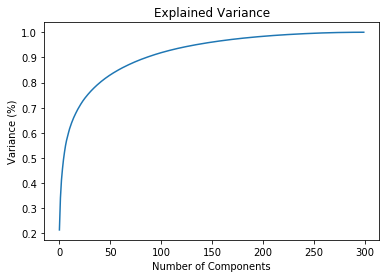

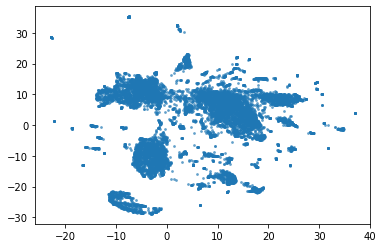

Number of outliers: 1745


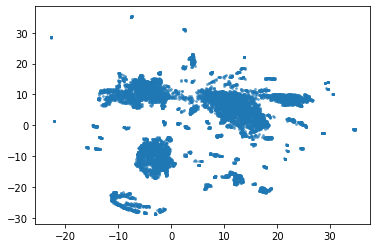

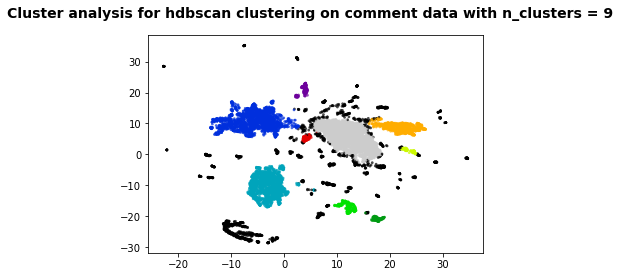

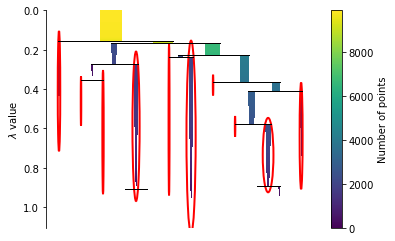

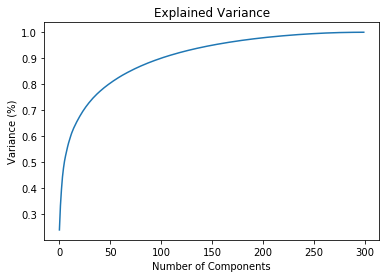

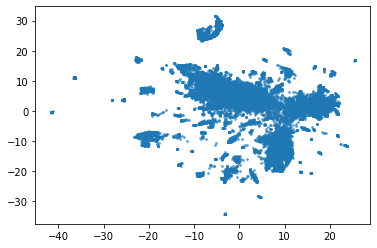

Number of outliers: 2133


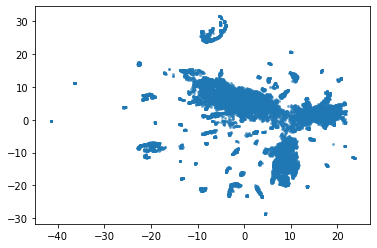

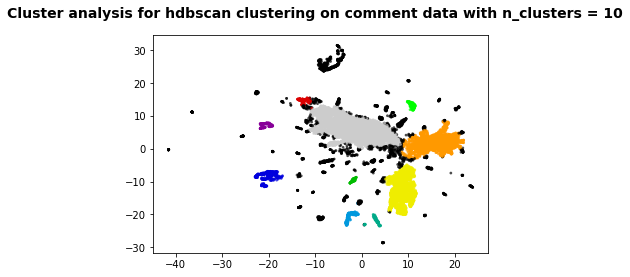

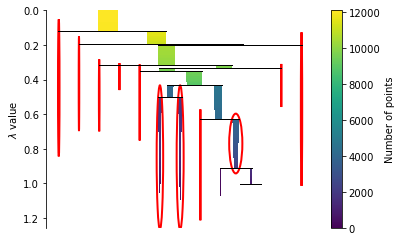

In [12]:
# Cluster validation for each question.

# Rewrite the csv.
with open('data_tm.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['Question', 'Comment', 'Mean Embedding', 'x', 'y', 'Cluster ID']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()

    # For each question, load all information into arrays.
    for name, group in df_embeddings.groupby(['Question']):
        
        embeddings = []
        comments = []
        questions = []
        
        for index, row in group.iterrows():
            # Exclude embeddings with nan values.
            if len(row['Mean Embedding']) > 6:
                embeddings.append(np.asarray(eval(row['Mean Embedding'])))
                comments.append(row['Comment'])
                questions.append(row['Question'])
        
        X = np.array(embeddings)
        C = np.array(comments)
        Q = np.array(questions)

        # Normalize values between 0 and 1. 
        scaler = MinMaxScaler(feature_range=[0, 1])
        data_rescaled = scaler.fit_transform(X)

        #Plot the cumulative summation of the explained variance.
        pca = PCA().fit(data_rescaled)
        plt.figure()
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title('Explained Variance')
        plt.show()

        # Reduce dimensions for performance while maintaining majority of variance.
        pca = PCA(n_components=150)
        data = pca.fit_transform(data_rescaled)

        # Perform UMAP dimensionality reduction to more cleanly separate clusters and improve performance.
        reducer = umap.UMAP(random_state=42, min_dist=0.0, spread=5, n_neighbors=19)
        data_reduced = reducer.fit(data).embedding_
        plt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
        plt.show()

        # Remove a certain percentage of outliers. Show the number of outliers.
        outlier_scores = LocalOutlierFactor(contamination=0.15).fit_predict(data_reduced)
        outlying_digits = data_reduced[outlier_scores == -1]
        print(f'Number of outliers: {outlying_digits.shape[0]}')
                                  
        # Transform all the lists according to the inlier data.        
        data_inliers = data_reduced[outlier_scores == 1]
        embeddings_inliers = X[outlier_scores == 1]
        comments_inliers = C[outlier_scores == 1]
        questions_inliers = Q[outlier_scores == 1]
        
        # Confirm that all the arrays are still the same length.
        if not len(data_inliers) == len(comments_inliers) == len(questions_inliers) == len(embeddings_inliers):
            print('Check your data. Something is faulty with the outliers.')
            break
                                  
        # Visualize the inlier data.
        plt.scatter(data_inliers[:, 0], data_inliers[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
        plt.show()

        # Cluster using hdbscan algorith, which identifies dense regions based on min_cluster size.
        # The algorithm also scores 'unclustered' points with a label -1.
        clusterer = hdbscan.HDBSCAN(algorithm='best', 
                                    alpha=1.0, 
                                    approx_min_span_tree=True,
                                    gen_min_span_tree=False, 
                                    leaf_size=40,
                                    metric='euclidean', 
                                    min_cluster_size=100, 
                                    min_samples=None, 
                                    p=None)
        
        clusterer.fit(data_inliers)
        cluster_labels = clusterer.labels_

        # Visualize the clusters.
        colors = cm.nipy_spectral(cluster_labels.astype(float) / clusterer.labels_.max())
        plt.scatter(data_inliers[:, 0], data_inliers[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')
        
        plt.suptitle(("Cluster analysis for hdbscan clustering on comment data"
                      " with n_clusters = %d" % clusterer.labels_.max()),
                     fontsize=14, fontweight='bold')

        plt.show()
        
        # Show a tree plot of how the clusters were formed.
        clusterer.condensed_tree_.plot(select_clusters=True,
                                       selection_palette=sns.color_palette('deep', 8))   
                    
        # Write everything to the csv.
        for i in range(len(data_inliers)):
            writer.writerow({'Question': questions_inliers[i],
                             'Comment': comments_inliers[i],
                             'Mean Embedding': embeddings_inliers[i],
                             'x': data_inliers[i][0],
                             'y': data_inliers[i][1],
                             'Cluster ID': cluster_labels[i]})

In [13]:
# Load the new df.
df_clustered = pd.read_csv('data_tm.csv')
df_clustered.head(10)

,Question,Comment,Mean Embedding,x,y,Cluster ID
0,Please tell us what is working well.,"we do what our customers need, we communicate ...",[ 1.13025932e-02 -2.16684099e-02 4.29682024e-...,-1.077249,-14.951020,3
1,Please tell us what is working well.,customs business development continues to grow...,[-7.62640825e-03 -2.55811289e-02 4.08375002e-...,11.188398,-15.714738,5
2,Please tell us what is working well.,"i think the team work hard, are committed to c...",[-2.62133166e-04 -2.03040056e-03 4.92807180e-...,-0.992750,-7.205764,3
3,Please tell us what is working well.,overall working towards a customer centric env...,[ 1.23251043e-03 -6.05461886e-03 4.55596782e-...,-6.247532,11.557572,2
4,Please tell us what is working well.,customer centricity is a growing culture in th...,[ 4.98220511e-03 -2.19332576e-02 4.49964032e-...,-2.710616,14.785033,2
5,Please tell us what is working well.,develop a comfortable rapport with clients and...,[ 3.33974161e-03 -1.52971577e-02 5.76605238e-...,10.379048,10.846996,9
6,Please tell us what is working well.,"we are usually seeking customer satisfaction, ...",[-3.10847983e-02 1.80149073e-04 3.28003354e-...,-9.954654,-22.932459,0
7,Please tell us what is working well.,alignment between regional office and country ...,[ 3.55969160e-03 -2.70363614e-02 3.94774340e-...,-3.401776,14.515742,2
8,Please tell us what is working well.,"innovation, customer relations ship and custom...",[-3.08258779e-04 -1.15033025e-02 2.64895074e-...,-5.305197,-9.952636,3
9,Please tell us what is working well.,to change the global forwarding business unit ...,[ 3.07564903e-03 -7.42605553e-05 4.81357612e-...,8.240479,10.556561,9


In [14]:
# Assign cluster labels based on TF-IDF key words.

# Rewrite the csv.
with open('data_tm.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['Question', 'Comment', 'Mean Embedding', 'x', 'y', 'Cluster ID', 'Cluster Keywords']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    
    # Group by question.
    for name, question in df_clustered.groupby(['Question']):
        
        # Within question, group by cluster.
        for name, cluster in question.groupby(['Cluster ID']):
            
            # Extract everything to lists (this step is kinda messy).
            cluster_ids = []
            cluster_keywords = []
            comments = []
            questions = []
            x = []
            y = []
            embeddings = []

            for index, row in cluster.iterrows():
                embeddings.append(row['Mean Embedding'])
                comments.append(row['Comment'])
                questions.append(row['Question'])
                x.append(row['x'])
                y.append(row['y'])
                cluster_ids.append(row['Cluster ID'])
              
            # Compute TF-IDF for all comments in the cluster.
            keywords = [key[0] for key in sorted(list(get_tfidf(comments).items()), key=lambda x: x[1], reverse=True)][0:10]
            for index, row in cluster.iterrows():
                cluster_keywords.append(keywords)
       
            # Write everything to the csv.
            for i in range(len(comments)):
                writer.writerow({'Question': questions[i],
                                'Comment': comments[i],
                                'Mean Embedding': embeddings[i],
                                 'x': x[i],
                                 'y': y[i],
                                'Cluster ID': cluster_ids[i],
                                'Cluster Keywords': cluster_keywords[i]})

In [15]:
# Load the final csv.
df_labeled = pd.read_csv('data_tm.csv')

In [16]:
# Drop comments for which hdbscan could not find a good cluster.
outliers = df_labeled[ df_labeled['Cluster ID'] == -1 ].index
df_labeled.drop(outliers , inplace=True)

Question: Please tell us what is working well.



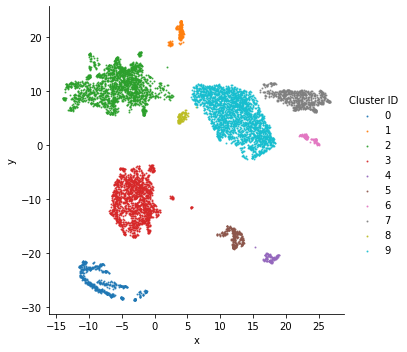

Cluster 0: ['Vision', 'Thank', 'Months', 'Bright', 'Loyal', 'Topics', 'Value', 'Pride', 'Enhancement', 'Supervisor'] 

we are usually seeking customer satisfaction, helping our custom on fixing problems what ever it is related to [company] or not.
it is great pleasure to see that all of us [company] employees are getting more and more customer centric and passionate to serve our customers this has resulted in best quality services commitment from employees cif played a big role.
credit card customers,working with [company], and some of our sales managers.
i would be a part of [company]
[company] bahrain is giving more importance to the customer.



Cluster 1: ['Think', 'Proud', 'Reopening', 'Openings', 'Changes', 'Want', 'Accepting', 'Nice', 'Inspired', 'Direction'] 

small and medium size us stations provide good service and communicate with customers effectively.
we work as a team and sporting eachothers and our menagement guid us that is a good.
regular customers that that ship with

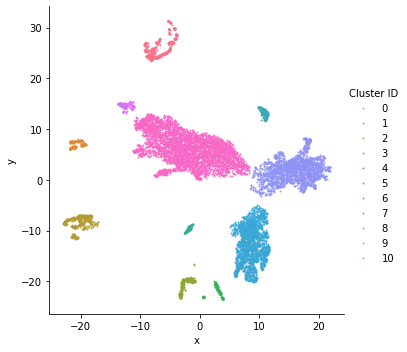

Cluster 0: ['Divisions', 'Years', 'Tracking', 'Course', 'Benefit', 'Internal', 'Certain', 'Receiving', 'Reporting', 'Teams'] 

not all our customer (bps) would have a high labor arbitrage hence our gsc leadership team and [company]f leadership need to think as how gsc can service all bps across our standard catalogue.
communication between [company] baku/ georgia and ilvc i believe needs to be stronger.
[company] needs user friendly systems that communicates with each other to save time, increase efficiency and productivity
i feel that not every department in [company] uk has bought into or are acting like freight forwarders, and that more could be implemented moving forward to develop all members of staff to be freight forwarders in their own right
all senior management need to visit customers more frequently to understand their real needs and not what [company] believe they are.



Cluster 1: ['Cross', 'Topics', 'Shifts', 'Benefit', 'Growth', 'Large', 'Warehouse', 'Notes', 'Outdated'

In [17]:
# Visualize the final results.
for name_question, question in df_labeled.groupby(['Question']):
    print(f'Question: {name_question}\n')
    
    # Visualize the UMAP reduced data with the cluster IDs.
    facet = sns.lmplot(data=question, x='x', y='y', hue='Cluster ID', 
                       fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})
    plt.show()
    
    # Show some of the comments for each cluster.
    for name_cluster, cluster in question.groupby(['Cluster ID']):
        cluster_name = cluster.head(1)['Cluster Keywords'].get_values().tolist()[0]
        print(f'Cluster {name_cluster}: {cluster_name.title()} \n')
        print(*cluster.head(5)['Comment'].get_values().tolist(), sep='\n')
        print('\n\n')

In [ ]:
# TODO: Refactor into different functions because some cells are getting pretty lengthy.
# TODO: Improve embeddings with fasttext.
# TODO: Improve embeddings with BERT.
# TODO: More sophisticated cluster labeling method beyond mere frequency (try the cluster projection library).
# TODO: More sophisticated and interactive cluster visualization.
# TODO: Custom metric for evaluating different clustering pipelines (get creative).
# TODO: Optimize the parameters of all functions in the clustering pipeline.